# GLM regression demo

In this notebook we demonstate *revrand*'s GLM fitting draws from a latent GP passed though various likelihood functions. The aim is to see how well the GLM can model the noisy targets.


In [9]:
%matplotlib inline

import matplotlib.pyplot as pl
pl.style.use('ggplot')
import numpy as np
import logging
from scipy.stats import poisson, bernoulli, binom, gamma
from scipy.special import expit

from revrand import likelihoods, GeneralizedLinearModel, Parameter, Positive
from revrand.utils.datasets import gen_gausprocess_se
from revrand import basis_functions as bs
from revrand.mathfun.special import softplus
from revrand.optimize import AdaDelta, Adam

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


## Dataset settings and latent function generation

In [10]:
N = 100  # Number of training points
Ns = 250  # Number of test points
lenscale_true = 1.2
noise_true = 0.1

Xtrain, ftrain, Xtest, ftest = \
            gen_gausprocess_se(N, Ns, lenscale=lenscale_true, noise=noise_true)
ytest = ftest + np.random.randn(Ns) * noise_true


## Algorithm Settings

In [11]:
nbases = 50  # Number of unique random bases to use for approximating a kernel
lenscale = gamma(1., scale=1.)  # Initial value for the lengthscale
var = gamma(.1, scale=1.)  # Initial value for target noise
reg = gamma(1., scale=1.)  # Initial weight prior

maxiter = 10000
batch_size = 10
updater = Adam()

# Setup random basis functions
len_ini = Parameter(lenscale, Positive())
basis = bs.RandomRBF(Xdim=1, nbases=nbases, lenscale_init=len_ini)


## Generic GLM calling code for learning, prediction and plotting


In [12]:
Xpl_t = Xtrain.flatten()
Xpl_s = Xtest.flatten()

def run_glm(ytrain, ytest, Ey_true, llhood, largs=(), slargs=(), plot_pgt1=False):
    
    # Learn
    glm = GeneralizedLinearModel(llhood,
                                 basis,
                                 regulariser=Parameter(reg, Positive()),
                                 batch_size=batch_size,
                                 maxiter=maxiter,
                                 updater=updater,
                                )
    glm.fit(Xtrain, ytrain, likelihood_args=largs)

    # Get expected y and variance
    Ey, Vy = glm.predict_moments(Xtest, likelihood_args=slargs)
    
    # p(y* <= 1)
    plt1, plt1n, plt1x = glm.predict_cdf(Xtest, 0, likelihood_args=slargs)
    
    # Get the 95% interval
    y95n, y95x = glm.predict_interval(Xtest, 0.95, likelihood_args=slargs)

    # Get the LP
    logp, _, _ = glm.predict_logpdf(Xtest, ytest, likelihood_args=slargs)
    
    print("Average log-likelihood: {}" .format(logp.mean()))

    # Training/Truth
    pl.figure(figsize=(15, 10))
    pl.plot(Xpl_t, ytrain, 'k.', label='Training')
    #pl.plot(Xpl_s, ftest, 'k-', label='Latent function')
    pl.plot(Xpl_s, Ey_true, 'g-', label='True $\mathbb{E}[y*]$')
    
    # Plot Regressor    
    pl.plot(Xpl_s, Ey, 'b-', label='GLM $\mathbb{E}[y*]$')
    pl.fill_between(Xpl_s, y95n, y95x, facecolor='none', edgecolor='b', label=None,
                    linestyle='--')

    if plot_pgt1:
        pl.plot(Xpl_s, 1 - plt1, 'r-', label='$\mathbb{E}[p(y >= 0)]$.')
        pl.fill_between(Xpl_s, 1 - plt1n, 1 - plt1x, facecolor='r', edgecolor='none',
                        label=None, alpha=0.3)

    pl.legend()
    pl.grid(True)
    pl.title('GLM prediction')
    pl.ylabel('y')
    pl.xlabel('x')

    # Plot Regressor posterior
    pl.figure(figsize=(15, 10))
    K = glm.weights_.shape[1]
    cols = pl.cm.jet(np.linspace(0, 1, K))
    for mk, Ck, c in zip(glm.weights_.T, glm.covariance_.T, cols):
        pl.plot(range(len(mk)), mk, color=c)
        pl.fill_between(range(len(mk)), mk - 2 * np.sqrt(Ck), mk + 2 * np.sqrt(Ck),
                        alpha=0.1, edgecolor='none', facecolor=c, label=None)

    pl.grid(True)
    pl.title('GLM Weight Posterior')
    pl.ylabel('w')
    pl.xlabel('basis index')

    pl.show()


## Gaussian likelihood

Average log-likelihood: -0.26597464156675416


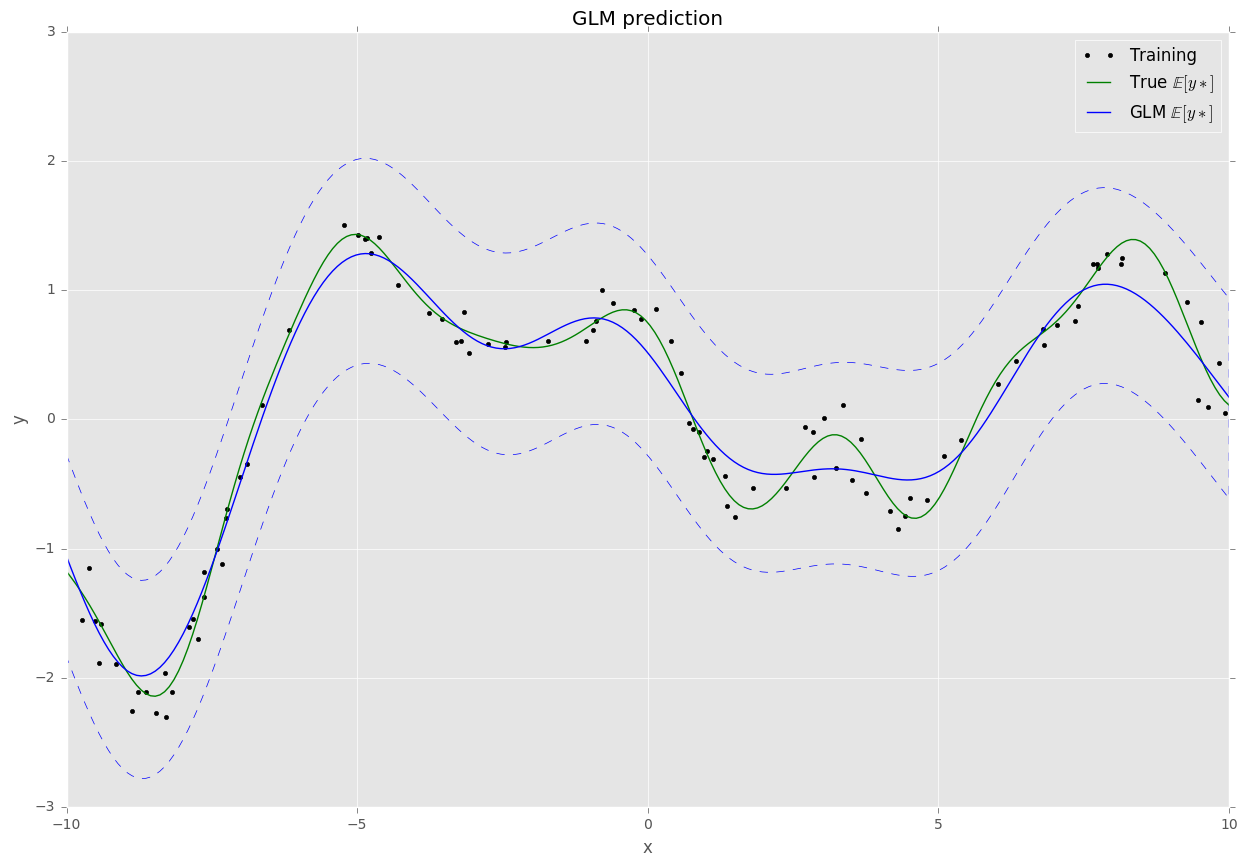

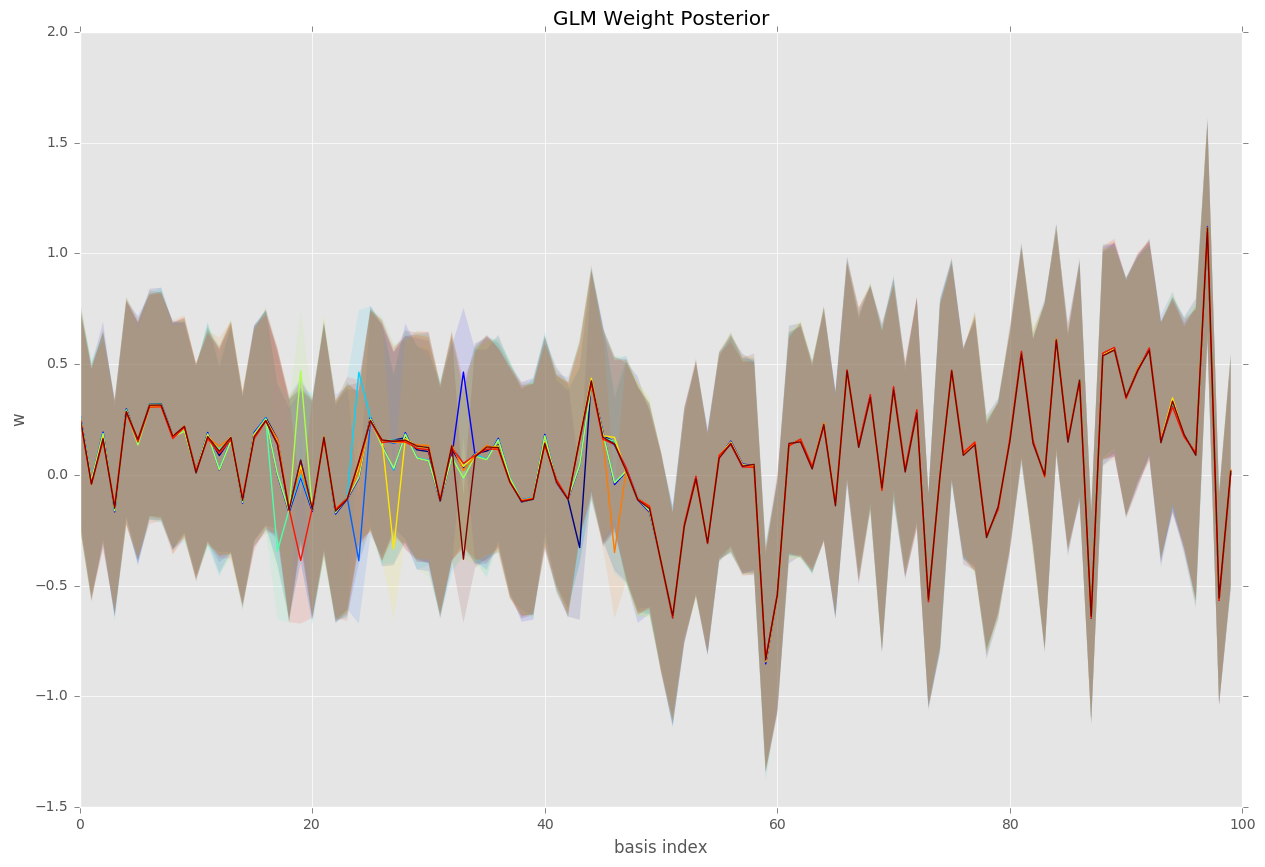

In [13]:
ytrain_gaus = ftrain + np.random.randn(N) * noise_true
ytest_gaus = ftest + np.random.randn(Ns) * noise_true
gauss = likelihoods.Gaussian(var_init=Parameter(var, Positive()))

run_glm(ytrain_gaus, ytest_gaus, ftest, gauss)


## Poisson Likelihood

Average log-likelihood: -1.835299511737237


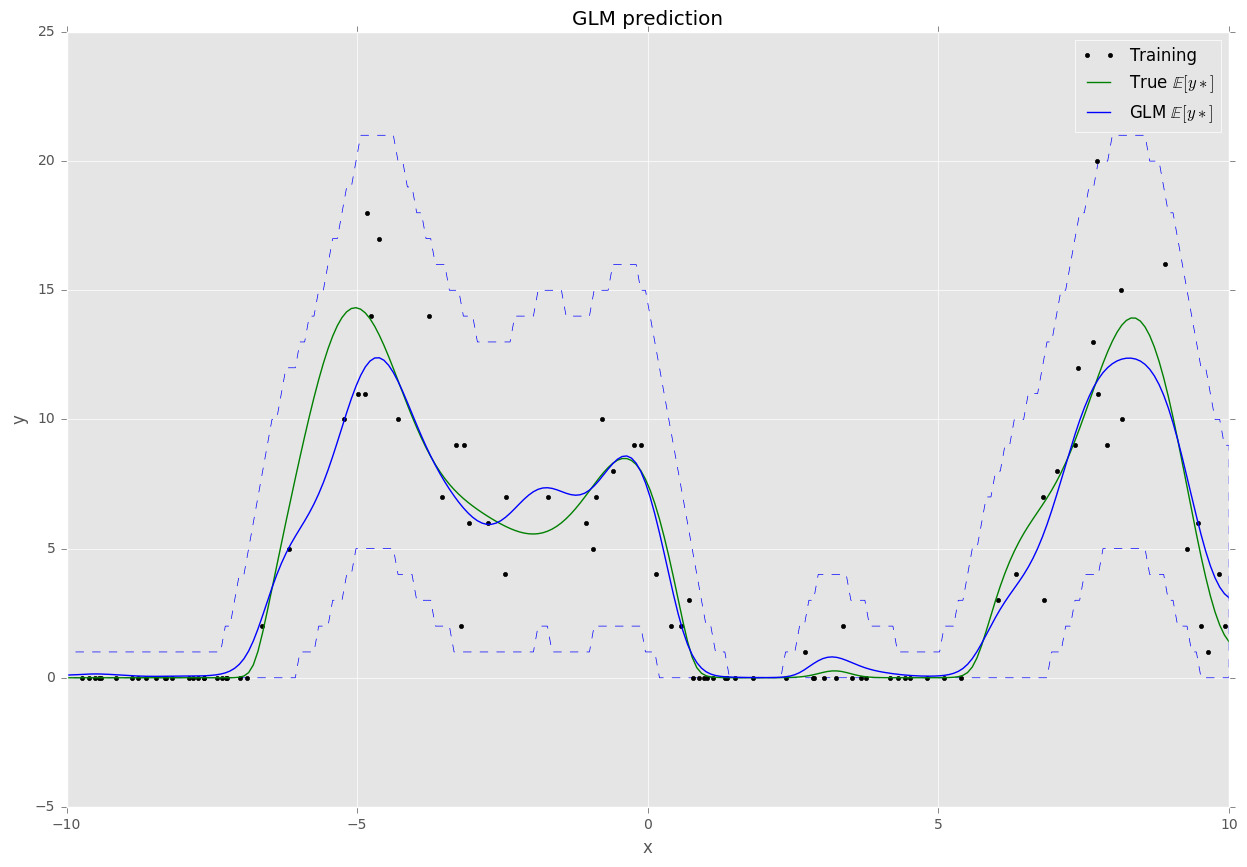

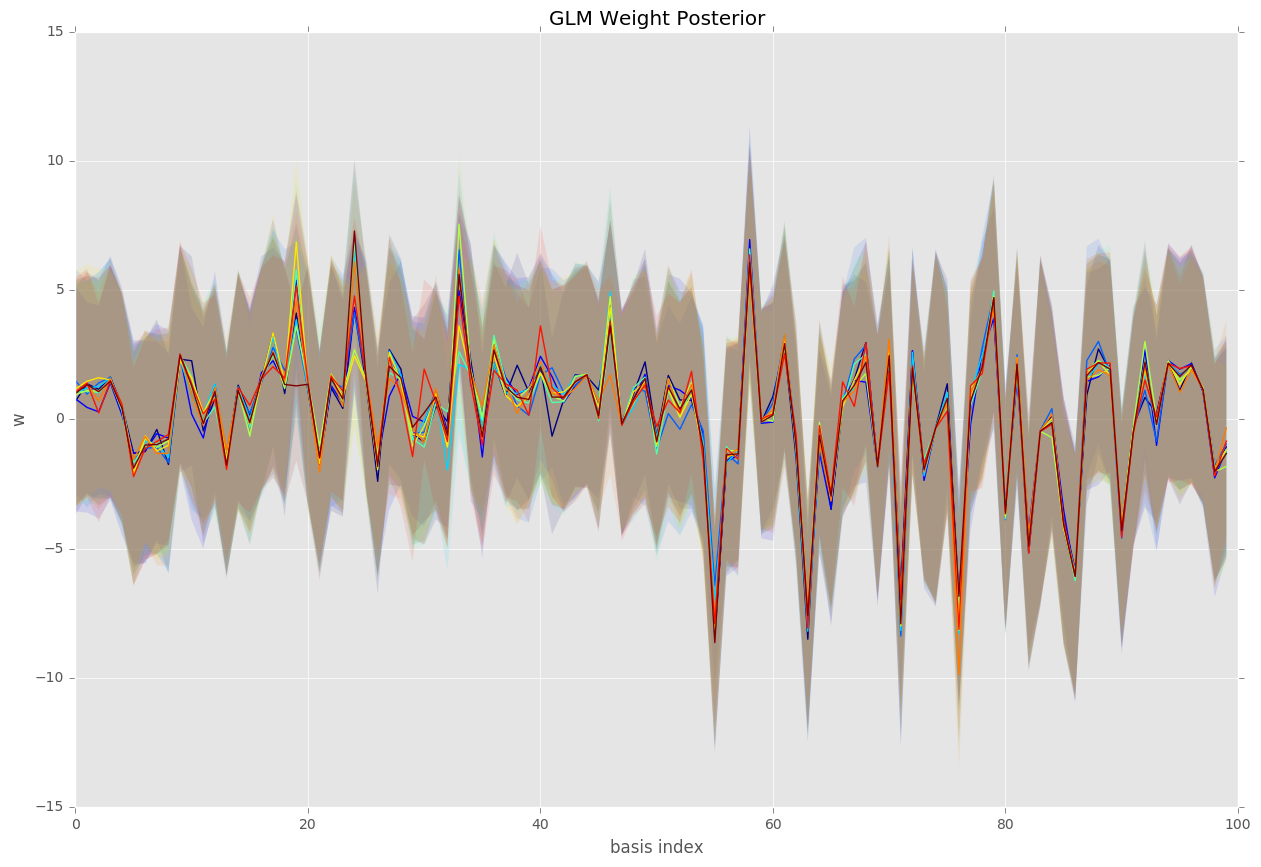

In [14]:
ytrain_pois = poisson.rvs(softplus(10 * ftrain))
Ey_true_pois = softplus(10 * ftest)
ytest_pois = poisson.rvs(Ey_true_pois)
pois = likelihoods.Poisson(tranfcn='softplus')

run_glm(ytrain_pois, ytest_pois, Ey_true_pois, pois)


## Bernoulli Likelihood

Average log-likelihood: -0.2295003801077195


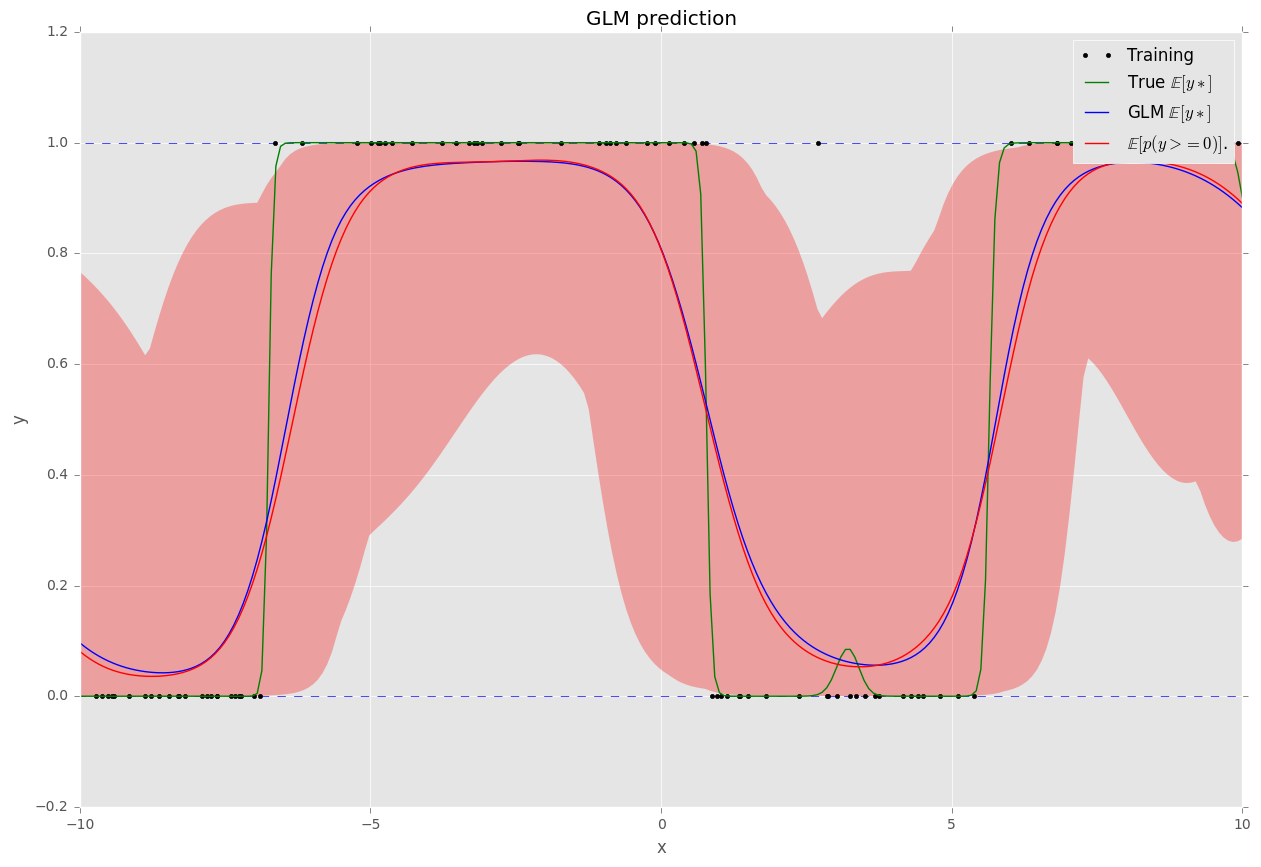

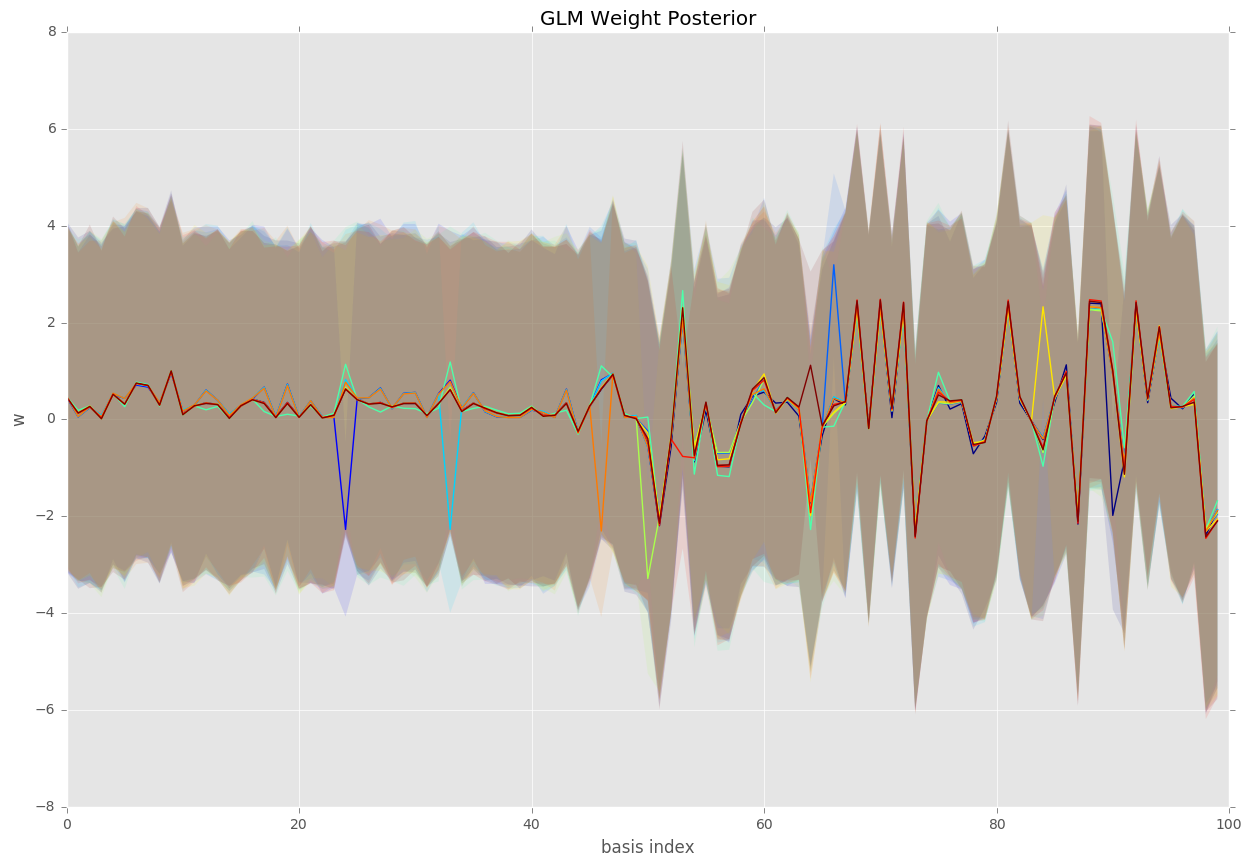

In [15]:
ytrain_bern = bernoulli.rvs(expit(20 * ftrain))
Ey_true_bern = expit(20 * ftest)
ytest_bern = bernoulli.rvs(Ey_true_bern)
bern = likelihoods.Bernoulli()

run_glm(ytrain_bern, ytest_bern, Ey_true_bern, bern, plot_pgt1=True)


## Binomial Likelihood

Average log-likelihood: -1.5256975655552325


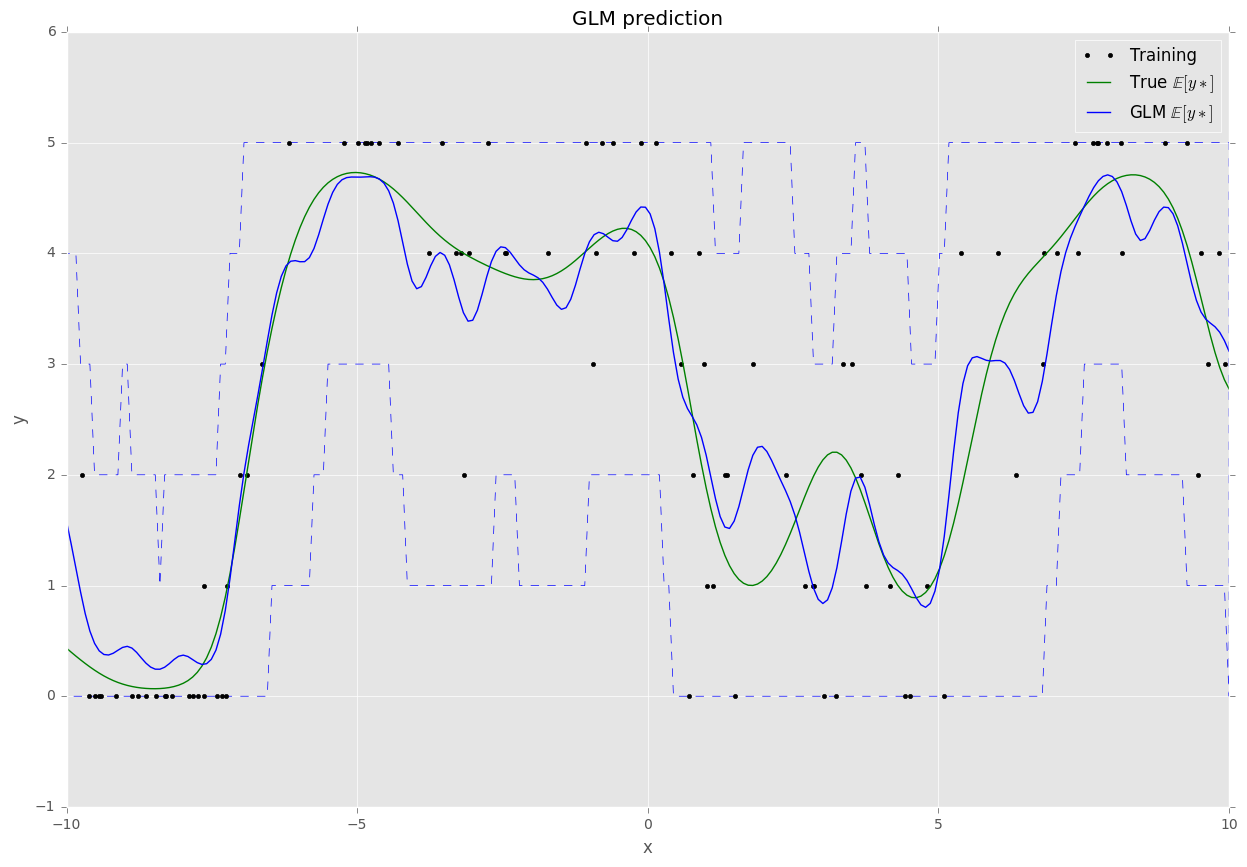

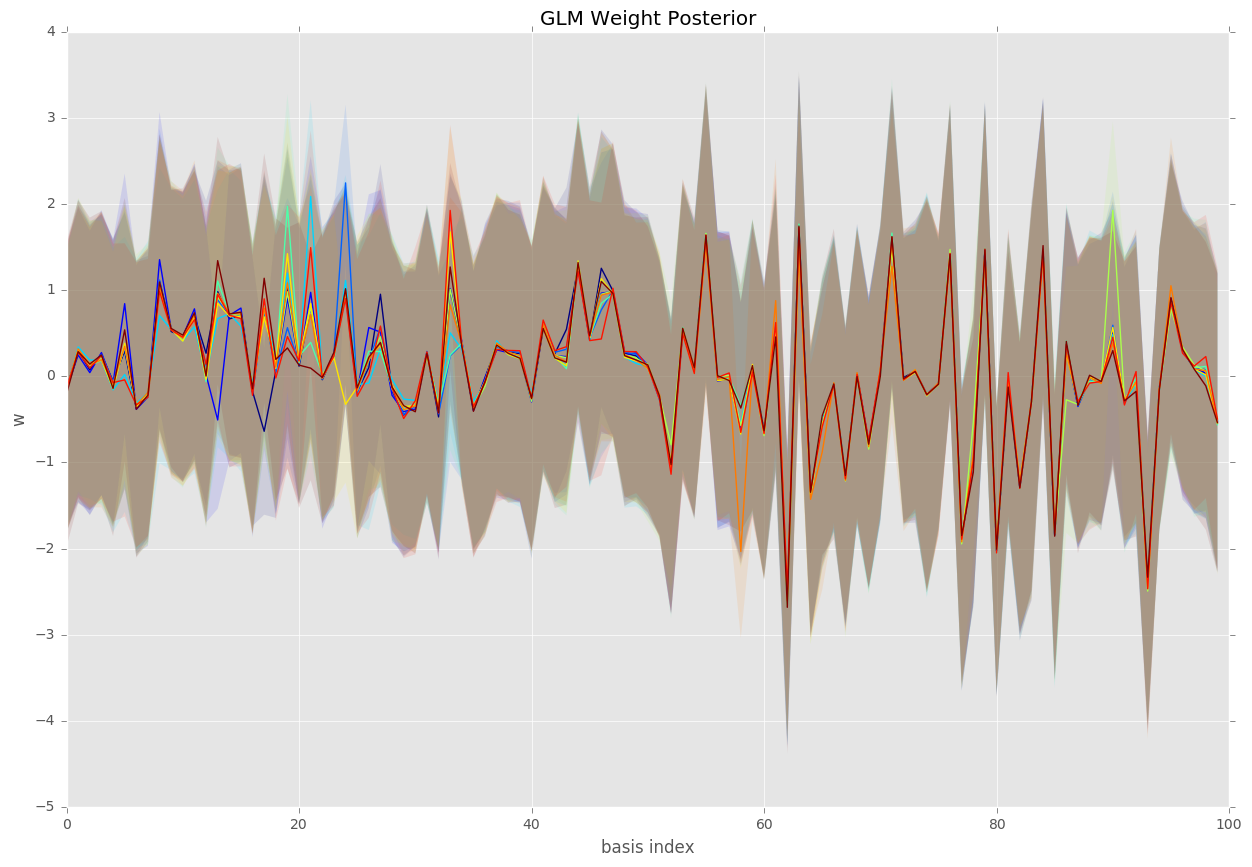

In [16]:
n = 5
ytrain_bin = binom.rvs(n=n, p=expit(2 * ftrain))
Ey_true_bin = n * expit(2 * ftest)
ytest_bin = binom.rvs(n=n, p=expit(2 * ftest))
largs = (n * np.ones(N, dtype=int),)
slargs = (n * np.ones(Ns, dtype=int),)
bino = likelihoods.Binomial()

run_glm(ytrain_bin, ytest_bin, Ey_true_bin, bino, largs, slargs)
